# EEG classification task: linear model

This notebook implements the machine learning part of an EEG motor imagery classification pipeline.

The main preprocessing steps were carried out in **Matlab**. For each session I applied the following steps:

1. **EOG artifact removal**  
   - Regress out EOG activity from the EEG channels using a linear regression model:

     EEGclean ​= EEG − XEOG * ​β 

     where 𝛽 is estimated on a 1-minute segment with strong eye movements.

2. **Band-pass filtering (2–45 Hz)**  
   - Apply a zero-phase Butterworth filter to retain the relevant EEG frequency band.

3. **Trial alignment and artifact rejection**  
   - Use trial onset markers to identify the motor-imagery period.
   - Remove trials marked as artifacts.

4. **Amplitude thresholding in the imagery period**  
   - Within each 3 s imagery window, set samples with amplitude > 60 µV to zero.

From these cleaned continuous signals we extracted:
- **3-channel imagery segments** (C3, Cz, C4) → used directly for **deep learning** models 
- **Bandpower features** over the 3 s imagery period → used for **linear models** (this notebook)

On top of these preprocessing steps, this notebook focuses on the **classification stage** where we train and evaluate linear models and compare their èerformence.

#### 0. Imports & config

In [2]:
import sys
from pathlib import Path

# Change this to your current project root:
PROJECT_ROOT = Path(r"C:\Users\elisa\Documents\elisa_projects\motor_imagery_EEG")
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from src.utils import load_feature_datasets

from src.data_processing import (
    standardize_features,
    sequ_feature_selection,
)
from src.data_visualisation import plot_class_distribution
from src.model_selection import hyperp_search

%matplotlib inline
plt.style.use("ggplot")
sns.set(font_scale=1.1)

%load_ext autoreload
%autoreload 2


#### 1. Load feature datasets

In [6]:
train_path = DATA_DIR / "feature_training_set.csv"
test_path  = DATA_DIR / "feature_test_set.csv"

X_train, X_test, y_train, y_test = load_feature_datasets(train_path, test_path)

X_train.head()


,8-10_Hz_ch1,9-11_Hz_ch1,10-12_Hz_ch1,11-13_Hz_ch1,12-14_Hz_ch1,13-15_Hz_ch1,14-16_Hz_ch1,15-17_Hz_ch1,16-18_Hz_ch1,17-19_Hz_ch1,...,15-21_Hz_ch3,16-22_Hz_ch3,17-23_Hz_ch3,18-24_Hz_ch3,19-25_Hz_ch3,20-26_Hz_ch3,21-27_Hz_ch3,22-28_Hz_ch3,23-29_Hz_ch3,24-30_Hz_ch3
0,1.073180,0.756706,2.269359,2.108115,0.502471,0.153452,0.102373,0.190985,0.199399,0.133889,...,0.865111,0.753033,0.791847,0.847954,0.836364,0.598785,0.371016,0.333642,0.251942,0.179266
1,0.971351,1.468591,6.672280,6.115909,1.169738,0.231232,0.112784,0.159151,0.258177,0.496363,...,0.821084,0.844117,0.824496,0.703109,0.614041,0.345747,0.184828,0.120212,0.121004,0.127673
2,0.165971,0.339063,1.519500,1.439737,0.565542,0.138605,0.140278,0.094352,0.144972,0.158510,...,0.892272,0.869804,0.879108,0.740434,0.737235,0.642878,0.297651,0.204011,0.305908,0.321564
3,1.394100,2.929213,5.720568,5.599439,0.622561,0.424732,0.292321,0.187989,0.646101,0.672264,...,0.499242,0.477935,0.451823,0.438508,0.448190,0.352545,0.219762,0.210770,0.220558,0.173824
4,0.663821,1.917813,5.193752,5.088646,0.520771,0.196372,0.228372,0.289395,0.514980,0.502612,...,0.853667,0.840598,0.790490,0.769639,0.739236,0.506991,0.411668,0.260003,0.301093,0.207532


##### 1.1 Class balance

Class counts:
Class
0    201
1    198
Name: count, dtype: int64


C:\Users\elisa\Documents\elisa_projects\motor_imagery_EEG\src\data_visualisation.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_series, palette=palette)


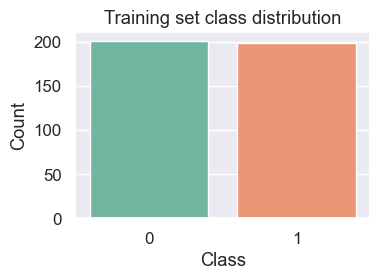

In [7]:
# Visualize class balance
plot_class_distribution(y_train, title="Training set class distribution")

#### 2. Standardize features

In [8]:
X_train_scaled, X_test_scaled, scaler = standardize_features(X_train, X_test)

X_train_scaled.head()

,8-10_Hz_ch1,9-11_Hz_ch1,10-12_Hz_ch1,11-13_Hz_ch1,12-14_Hz_ch1,13-15_Hz_ch1,14-16_Hz_ch1,15-17_Hz_ch1,16-18_Hz_ch1,17-19_Hz_ch1,...,15-21_Hz_ch3,16-22_Hz_ch3,17-23_Hz_ch3,18-24_Hz_ch3,19-25_Hz_ch3,20-26_Hz_ch3,21-27_Hz_ch3,22-28_Hz_ch3,23-29_Hz_ch3,24-30_Hz_ch3
0,-0.218365,-0.655636,-0.747476,-0.711136,-0.360764,-0.676228,-0.795878,-0.090818,-0.299774,-0.817406,...,-0.272900,-0.535290,-0.486853,-0.280388,0.003093,-0.148007,-0.568660,-0.438926,-0.613279,-0.905374
1,-0.281592,-0.413859,0.568960,0.793063,0.980081,-0.119096,-0.708652,-0.315906,0.032473,0.734036,...,-0.356428,-0.368260,-0.427362,-0.557599,-0.502911,-0.897279,-1.328490,-1.539244,-1.517011,-1.381815
2,-0.781658,-0.797479,-0.971678,-0.961990,-0.234026,-0.782575,-0.478300,-0.774078,-0.607420,-0.712027,...,-0.221369,-0.321156,-0.327851,-0.486165,-0.222524,-0.017443,-0.868061,-1.107224,-0.240807,0.408686
3,-0.019104,0.082210,0.284406,0.599222,-0.119450,1.266924,0.795565,-0.112004,2.225228,1.486915,...,-0.967036,-1.039763,-1.106428,-1.064005,-0.880385,-0.877149,-1.185925,-1.072383,-0.829889,-0.955625
4,-0.472539,-0.261290,0.126893,0.407512,-0.323992,-0.368793,0.259785,0.605004,1.484063,0.760779,...,-0.294612,-0.374715,-0.489328,-0.430271,-0.217970,-0.419820,-0.402762,-0.818566,-0.274036,-0.644349


#### 3. Feature selection with LDA

In [9]:
lda = LinearDiscriminantAnalysis()

X_train_fs, selected_features = sequ_feature_selection(
    estimator=lda,
    n_features=10,
    X=X_train_scaled,
    y=y_train,
    corr_based=False,
    method="SFS",
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    4.1s finished

[2025-11-09 23:21:12] Features: 1/10 -- score: 0.7192982456140351[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 139 out of 170 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.1s finished

[2025-11-09 23:21:12] Features: 2/10 -- score: 0.8145363408521303[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished

[2025-11-09 23:21:12] Features: 3/10 -- score: 0.8320802005012532[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jo

Results for different feature section methods:
- corr_based=False, type_selection='SBS'
['10-12_Hz_ch1','22-24_Hz_ch1','26-28_Hz_ch1','17-21_Hz_ch1','19-21_Hz_ch2',
 '13-17_Hz_ch2','14-18_Hz_ch2','10-12_Hz_ch3','19-21_Hz_ch3','21-23_Hz_ch3'],
 score: 0.8395989974937343
- corr_based=True, type_selection='SBS'
['11-13_Hz_ch1','13-15_Hz_ch1','19-21_Hz_ch1','26-28_Hz_ch1','14-18_Hz_ch2',
 '11-13_Hz_ch3','12-14_Hz_ch3','19-21_Hz_ch3','27-29_Hz_ch3','25-29_Hz_ch3']
 score: 0.8345864661654135
- corr_based=True, type_selection='SFS'
['11-13_Hz_ch1','15-17_Hz_ch1','16-18_Hz_ch1','17-19_Hz_ch1','25-27_Hz_ch1',
 '11-13_Hz_ch2','11-13_Hz_ch3','14-16_Hz_ch3','20-22_Hz_ch3','22-24_Hz_ch3'] 
 score: 0.8421052631578947
- corr_based=False, type_selection='SFS' 
['10-12_Hz_ch1','20-22_Hz_ch1','13-19_Hz_ch1','18-20_Hz_ch2','17-21_Hz_ch2',
 '10-12_Hz_ch3','13-15_Hz_ch3','24-26_Hz_ch3','9-13_Hz_ch3','19-23_Hz_ch3']
 score: 0.8646616541353384

In [10]:
print("Selected features:")
for f in selected_features:
    print(" -", f)

X_test_fs = X_test_scaled[selected_features]

Selected features:
 - 10-12_Hz_ch1
 - 20-22_Hz_ch1
 - 13-19_Hz_ch1
 - 18-20_Hz_ch2
 - 17-21_Hz_ch2
 - 10-12_Hz_ch3
 - 13-15_Hz_ch3
 - 24-26_Hz_ch3
 - 9-13_Hz_ch3
 - 19-23_Hz_ch3


#### 4. Hyperparameter search

##### 4.1  Logistic Regression

Best CV accuracy: 0.845 using {'C': 1.0, 'class_weight': None}
Test accuracy: 0.844


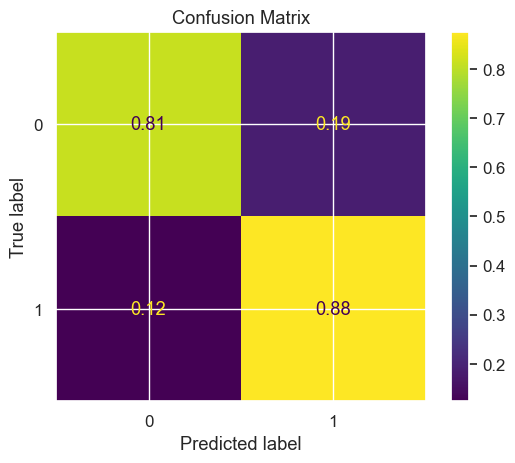

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       154
           1       0.82      0.88      0.85       153

    accuracy                           0.84       307
   macro avg       0.85      0.84      0.84       307
weighted avg       0.85      0.84      0.84       307



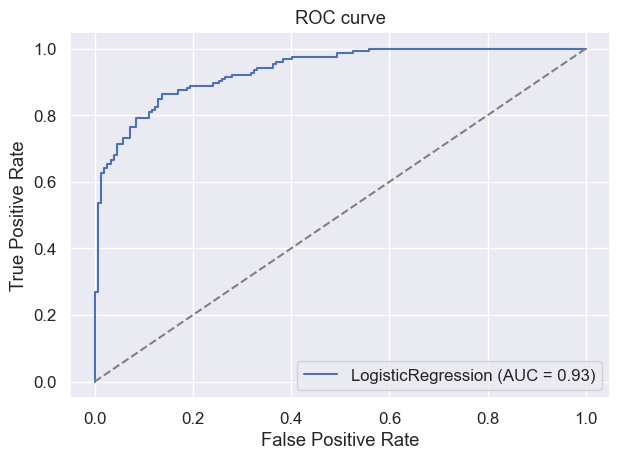

In [15]:
log_reg = LogisticRegression(max_iter=1000)
log_reg_params = {
    "C": [0.1, 1.0, 10.0],
    "class_weight": [None, "balanced"],
}
best_log_reg, acc_log, y_pred_log, y_proba_log = hyperp_search(
    log_reg, log_reg_params, X_train_fs, y_train, X_test_fs, y_test,
    class_labels=["left", "right"],  # or ["0", "1"]
)

##### 4.2 Linear Discriminant Analysis (LDA)

Best CV accuracy: 0.865 using {'solver': 'svd'}
Test accuracy: 0.866


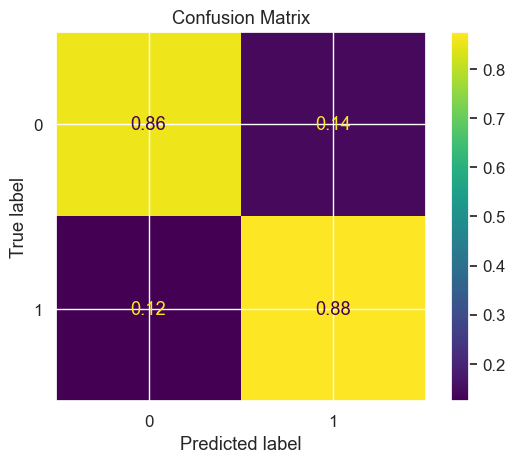

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       154
           1       0.86      0.88      0.87       153

    accuracy                           0.87       307
   macro avg       0.87      0.87      0.87       307
weighted avg       0.87      0.87      0.87       307



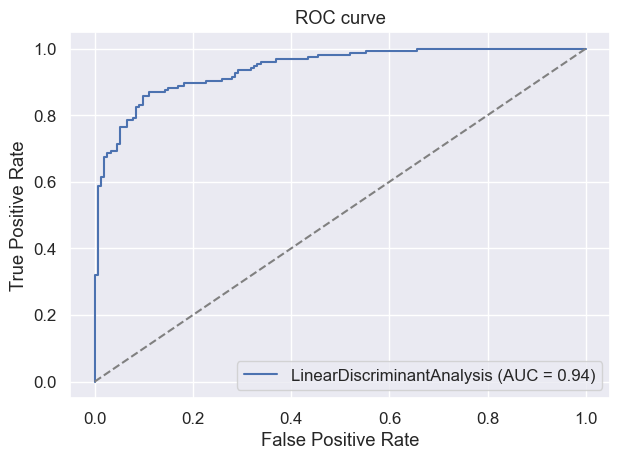

In [16]:
lda_model = LinearDiscriminantAnalysis()
lda_params = {"solver": ["svd", "lsqr", "eigen"]}

best_lda, acc_lda, y_pred_lda, y_proba_lda = hyperp_search(
    lda_model, lda_params, X_train_fs, y_train, X_test_fs, y_test,
    class_labels=["left", "right"],
)

#### 5. Save Results

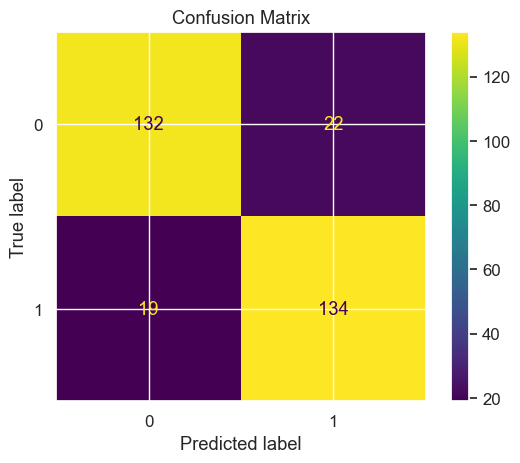

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       154
           1       0.86      0.88      0.87       153

    accuracy                           0.87       307
   macro avg       0.87      0.87      0.87       307
weighted avg       0.87      0.87      0.87       307



<Figure size 640x480 with 0 Axes>

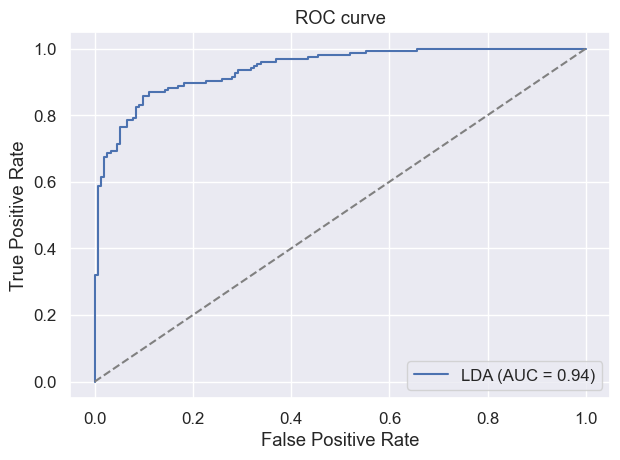

Results saved to C:\Users\elisa\Documents\elisa_projects\motor_imagery_EEG\results
 - Confusion matrix: LDA_confusion_matrix.png
 - ROC curve: LDA_roc_curve.png
 - Classification report: LDA_classification_report.txt


<Figure size 640x480 with 0 Axes>

In [18]:
from src.utils import save_linear_results


save_linear_results(
    y_true=y_test.to_numpy(),
    y_pred=y_pred_lda,
    y_pred_proba=y_proba_lda,
    results_dir=RESULTS_DIR,
    model_name="LDA",
    class_labels=["left", "right"],
)